In [ ]:
# default_exp modeling.seq2seq.core

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.seq2seq.core

> This module contains core custom models, loss functions, etc... for Seq2Seq based tasks (e.g., language modeling, summarization, translation, etc...)

In [ ]:
#export
import ast, inspect, torch

from transformers import *
from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import get_blurr_tfm
from blurr.data.seq2seq.core import *
from blurr.modeling.core import *

from datasets import load_metric as hf_load_metric, list_metrics as hf_list_metrics

import nltk
nltk.download('wordnet', quiet=True)

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.8.1+cu102
Using fastai 2.3.1
Using transformers 4.5.1


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Seq2Seq

In [ ]:
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv')

cnndm_df.head(2)

,article,highlights,ds_type
0,"(CNN) -- Globalization washes like a flood over the world's cultures and economies. Floods can be destructive; however, they can also bring blessings, as the annual floods of the Nile did for ancient Egypt. The world's great universities can be crucial instruments in shaping, in a positive way, humankind's reaction to globalization and the development of humankind itself. Traditionally, universities have been defined and limited by location, creating an academic community and drawing students and scholars to that place. Eventually, some universities began to encourage students to study el...","John Sexton: Traditionally, universities have been defined and limited by location .\nGlobal campuses form a network of thought, innovation, he writes .\nFaculty can teach, Sexton says, students can team up in many cities at once .\nSexton: Research, scholarship can be shared and cultural ties made in ""century of knowledge""",train
1,"(CNN) -- Armenian President Robert Kocharian declared a state of emergency Saturday night after a day of clashes between police and protesters, a spokeswoman for the Armenian Foreign Ministry said. Opposition supporters wave an Armenian flag during a protest rally in Yerevan, Armenia, on Saturday. The protesters claim last month's presidential election was rigged. The state of emergency will ""hopefully bring some order"" to the capital, Yerevan, said Salpi Ghazarian, assistant to the Armenian foreign minister, who spoke to CNN early Sunday. The state of emergency could last until March 20, ...","NEW: Protest moves after crackdown at Freedom Square .\nOrder sought after protests over last month's election turn violent .\nDemonstrators say the election was fraudulent .\nState of emergency could last until March 20, official says .",train


In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                  max_length=256, max_target_length=130)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(cnndm_df, bs=2)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 84]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"(CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence of the country's rich wildlife. And there is a great deal to lose. In the United Nations Environment Program (UNEP) World Conservation Monitoring Centre's list of megadiverse countries Mexico ranks 11th. The list represents a group of 17 countries that harbor the majority of the Earth's species and are therefore considered extremely biodiverse. From its coral reefs in the Caribbean Sea to its tropical jungles in Chiapas and the Yucatan peninsula and its deserts and prairies in the north, Mexico boasts an incredibly rich variety of flora and fauna. Some 574 out of 717 reptile species found in Mexico -- the most in any country -- can only be encountered within its borders. It is home to 502 types of mammals, 290 species of birds, 1,150 varieties of birds and 26,000 classifications of plants. Pronatura, a non-profit organization that works to promote conservation and sustainable development in Mexico, has selected six species which it says symbolize the problems faced by the","Mexico hosts to up to 10 percent of all known species on Earth.\nIt is home to 502 types of mammals, 290 bird species and 26,000 types of plants.\nHuman development and climate change is placing a big strain on its biodiversity.\nThe Golden Eagle is under threat in spite of being the country's national symbol."
1,"(CNN) -- It's a congested, sprawling transport hub surrounded by 1950s architecture and predominantly used by commuters or tourists to cross the city of Istanbul. But proposed changes to Taksim Square have seen it become the flashpoint for protests that have swept through Turkey in the past week, leaving thousands injured and focusing the world's attention on the government of Prime Minister Recep Tayyip Erdogan. Taksim has been no stranger to violence. In 1977, at least 34 protesters died during May Day clashes with police. May 1 rallies in the square were banned in 1980 and were only allowed to legally resume in 2010. On May Day this year, there were riots after city authorities again refused to grant trade unions and youth groups permission to demonstrate in Taksim, blaming construction work being carried out in the square. Professor Ersin Kalaycioglu, professor of political science at Istanbul's Sabanci University, said significantly, Taksim Square was also known as ""republic square,"" because it was built by the Republic of Turkey's founding fathers to commemorate the war of liberation. ""Taksim Square is connected to Istiklal Caddesi -- Independence Avenue -- and Cumhuriyet Caddesi -- the Avenue of the Republic. So there",Taksim Square was where Istanbul's water was distributed -- Taksim means divide.\nThe site is seen as symbolizing the seclar Turkish republic founded by Ataturk.\nErdogan's government's plans to alter Taksim's Gezi Park prompted protests.\nThe police's heavy-handed response saw demonstrators' numbers surge.


### Training

Here we create a Seq2Seq specific subclass of `HF_BaseModelCallback` in order to include custom, Seq2Seq specific, metrics, and also handle the pre-calculated loss during training

seq2seq_metrics
- {'rouge': { 'compute_args': {'return_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True}, 'returns':["rouge1", "rouge2", "rougeL"]}
- {'bert_score': { 'returns': ["precision", "recall", "f1"] }
- {'bleu': { 'returns': "bleu" }
- {'bleurt': { 'returns': "scores" }
- {'meteor': { 'returns': "meteor" }
- {'sacrebleu': { 'returns': "score" }

In [ ]:
#export
class HF_Seq2SeqMetricsCallback(Callback):  
    def __init__(self, custom_metrics=None, ignore_token_id=CrossEntropyLossFlat().ignore_index, 
                 text_gen_kwargs={}, **kwargs):
        
        super().__init__(**kwargs)
        self.order = Recorder.order-1   
        
        store_attr(self=self, names='custom_metrics, ignore_token_id, text_gen_kwargs, kwargs')
        self.custom_metric_funcs, self.custom_metric_vals = {}, {}
        
        if (custom_metrics is not None):
            for metric_name, metric_info_dict in custom_metrics.items():
                # self.custom_metric_funcs (tuple): the function to compute the metric and what should be returned,
                # if the "compute_func" is not defined, we assume it is a huggingface metric
                if ('compute_func' in metric_info_dict):
                    compute_func = metric_info_dict['compute_func']
                else:
                    compute_func = hf_load_metric(metric_name).compute
                    
                compute_kwargs = metric_info_dict['compute_kwargs'] if ('compute_kwargs' in metric_info_dict) else {}
                metric_returns = metric_info_dict['returns']
        
                self.custom_metric_funcs[metric_name] = (partial(compute_func, **compute_kwargs),  metric_returns)
                
                # self.custom_metric_vals (list): all the custom metrics to report as a "ValueMetric"
                if (metric_name == 'rouge'): 
                    self.custom_metric_vals.update({ rouge_type:None for rouge_type in metric_returns })
                elif (is_listy(metric_returns)):
                    self.custom_metric_vals.update({ f'{metric_name}_{ret_val}':None for ret_val in metric_returns })
                else:
                    self.custom_metric_vals.update({ metric_name:None })

        self.do_setup = True
        
    def setup(self):
        # one time setup code here.
        if (not self.do_setup): return
        
        # grab the hf_tokenizer from the HF_BeforeBatchTransform (used for rouge metrics)
        hf_before_batch_tfm = get_blurr_tfm(self.learn.dls.before_batch)
        self.hf_tokenizer = hf_before_batch_tfm.hf_tokenizer
        self.tok_kwargs = hf_before_batch_tfm.tok_kwargs
        
        # use before batch tfm's text_gen_kwargs if user doesn't pass in their own kwargs
        if (len(self.text_gen_kwargs) == 0): self.text_gen_kwargs = hf_before_batch_tfm.text_gen_kwargs
        
        # add seq2seq generation specific metrics (rouge, bertscore, bleu, etc...) to learner metrics
        metric_keys = list(self.custom_metric_vals.keys())
        custom_metrics = L([ ValueMetric(partial(self.metric_value, metric_key=k), k) for k in metric_keys ])
        self.learn.metrics = self.learn.metrics + custom_metrics
        
        self.do_setup = False
        
    def before_fit(self): self.setup()
        
        
    # --- batch begin/after phases ---
    def after_batch(self):
        if (self.training or self.learn.y is None or self.custom_metrics is None): return
        
        # grab predicted and reference ids for any metrics that need them
        input_ids, attention_mask = self.xb[0]['input_ids'], self.xb[0]['attention_mask']
        gen_ids = self.learn.model.hf_model.generate(input_ids=input_ids, 
                                                     attention_mask=attention_mask, 
                                                     **self.text_gen_kwargs)
        
        self.generated_ids += gen_ids.tolist()
        self.refernce_ids += [ seq[seq != self.ignore_token_id].tolist()  for seq in self.yb[0] ]

    # --- validation begin/after phases ---
    def before_validate(self): self.generated_ids, self.refernce_ids = [], []
        
    def after_validate(self):
        if (self.learn.y is None or self.custom_metrics is None): return
        
        # fetch the generated prediction and reference tokens and texts
        gen_toks = [ self.hf_tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True) 
                    for ids in self.generated_ids ]
        
        ref_toks = [ self.hf_tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True) 
                    for ids in self.refernce_ids ]
        
        gen_texts = self.hf_tokenizer.batch_decode(self.generated_ids, 
                                                   skip_special_tokens=True, 
                                                   clean_up_tokenization_spaces=True)
        
        ref_texts = self.hf_tokenizer.batch_decode(self.refernce_ids, 
                                                   skip_special_tokens=True, 
                                                   clean_up_tokenization_spaces=True)
            
        # calculate any seq2seq metrics
        for metric_name, metric_info in self.custom_metric_funcs.items():
            compute_func, return_val = metric_info
            
            # some metrics work on tokens (bleu), some allow for multiple references (blue, sacrebleu), and most
            # work directly on the generated and reference texts; here blurr does the dirty work of getting your
            # preds/references formatted for the metric you are using
            if (metric_name == 'bleu'):
                predictions, references = gen_toks, [ [toks] for toks in ref_toks ]
            elif (metric_name == 'sacrebleu'):
                predictions, references = gen_texts, [ [txt] for txt in ref_texts ]
            else:
                predictions, references = gen_texts, ref_texts
                
            # calls the metrics "compute" function
            res = compute_func(predictions=predictions, references=references)
            
            # updates the custom_metric_vals with the metric's value
            if (metric_name == 'rouge'):
                for rouge_key, scores in res.items(): 
                    self.custom_metric_vals[rouge_key] = scores.mid.fmeasure
            if (metric_name == 'bertscore'):
                for score_key, score in res.items(): 
                    if (f'{metric_name}_{score_key}' not in self.custom_metric_vals): continue
                    self.custom_metric_vals[f'{metric_name}_{score_key}'] = np.array(score).mean().item()
            elif (is_listy(return_val)):
                for score_key, score in res.items(): 
                    if (f'{metric_name}_{score_key}' not in self.custom_metric_vals): continue
                    self.custom_metric_vals[f'{metric_name}_{score_key}'] = score
            else:
                self.custom_metric_vals[metric_name] = res[return_val]
                

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key): return self.custom_metric_vals[metric_key]

We add a custom param splitter to give us a bit more depth in applying discriminative learning rates for Seq2Seq tasks.

In [ ]:
#export
def seq2seq_splitter(m, arch):
    """Custom param splitter for summarization models"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m

    if arch in ['bart', 'blenderbot', 'blenderbot_small', 'fsmt', 'marian', 'mbart', 'pegasus']:     
        embeds_modules = [
            model.model.encoder.embed_positions, 
            model.model.encoder.embed_tokens,
            model.model.decoder.embed_positions, 
            model.model.decoder.embed_tokens
        ]
        if arch != 'fsmt': embeds_modules.insert(0, model.model.shared)
            
        embeds = nn.Sequential(*embeds_modules)
        groups = L(embeds, model.model.encoder, model.model.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    
    if arch in['led']:
        embeds_modules = [
            model.led.encoder.embed_positions, 
            model.led.encoder.embed_tokens,
            model.led.decoder.embed_positions, 
            model.led.decoder.embed_tokens
        ]

        embeds = nn.Sequential(*embeds_modules)
        groups = L(embeds, model.led.encoder, model.led.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    
    if arch in['mt5', 't5']:
        embeds = nn.Sequential(
            model.shared, 
            model.encoder.embed_tokens,
            model.decoder.embed_tokens
        )
        
        groups = L(embeds, model.encoder, model.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)
    
    if arch in ['prophetnet', 'xlm_prophetnet']:
        embeds = nn.Sequential(
            model.prophetnet.word_embeddings, 
            model.prophetnet.encoder.word_embeddings, 
            model.prophetnet.encoder.position_embeddings, 
            model.prophetnet.decoder.word_embeddings, 
            model.prophetnet.decoder.position_embeddings, 
            model.prophetnet.decoder.ngram_embeddings 
        )
        
        groups = L(embeds, model.prophetnet.encoder.layers, model.prophetnet.decoder.layers, model.lm_head)
        return groups.map(params).filter(lambda el: len(el) > 0)
    
    
    raise ValueError(f'seq2seq_splitter does not support this architecutre: {arch}')

In [ ]:
show_doc(seq2seq_splitter)

<h4 id="seq2seq_splitter" class="doc_header"><code>seq2seq_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>seq2seq_splitter</code>(**`m`**, **`arch`**)

Custom param splitter for summarization models

In [ ]:
seq2seq_metrics = {
    'rouge': {
        'compute_kwargs': {
            'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True
        }, 
        'returns': ["rouge1", "rouge2", "rougeL"] 
    },
    'bertscore': {
        'compute_kwargs': { 'lang': 'en' },
        'returns': ["precision", "recall", "f1"]
    }, 
    'bleu': { 'returns': "bleu" },
    'meteor': { 'returns': "meteor" },
    'sacrebleu': { 'returns': "score" }
}

model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), #HF_PreCalculatedLoss()
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)) #.to_native_fp16() #.to_fp16()

learn.freeze()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds),preds['loss'].shape, preds['logits'].shape

(4, torch.Size([]), torch.Size([2, 69, 50264]))

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds),preds['loss'].shape, preds['logits'].shape

(4, torch.Size([]), torch.Size([2, 69, 50264]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=6.309573450380412e-07)

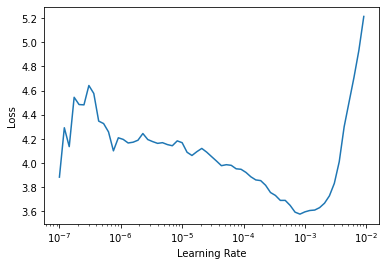

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,bleu,meteor,sacrebleu,time
0,1.835147,1.645218,0.390021,0.174499,0.265284,0.875935,0.894593,0.885088,0.151584,0.309012,12.513763,03:19


### Showing results

Below we'll add in additional functionality to take advantage of huggingface's `PreTrainedModel.generate` model, which can be used to easily implement beam search, top-k/nucleous sampling, etc... so that we get more human sounding results.

In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
res = learn.blurr_predict(test_article)
print(hf_tokenizer.decode(res[0][0][0][:20]))

<s><s>                About 10 men armed with pistols and machine machine guns raid a casino in Switzerland. made


That doesn't look much like a human-generated text.  Let's use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [ ]:
b = dls.valid.one_batch()

b_before_batch_tfm = get_blurr_tfm(dls.before_batch)

b_hf_tokenizer = b_before_batch_tfm.hf_tokenizer
b_ignore_token_id = b_before_batch_tfm.ignore_token_id

test_input_ids = b[0]['input_ids'][0].unsqueeze(0).to(learn.model.hf_model.device)
test_trg_ids = b[1][0].unsqueeze(0).to(learn.model.hf_model.device)
test_trg_ids = [ trg[trg != b_ignore_token_id] for trg in test_trg_ids ]

gen_text = learn.model.hf_model.generate(test_input_ids, num_beams=4, max_length=130, min_length=30)

print('=== Target ===')
print(f'{b_hf_tokenizer.decode(test_trg_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)}\n')

print('=== Prediction ===')
print(b_hf_tokenizer.decode(gen_text[0], skip_special_tokens=True, clean_up_tokenization_spaces=True))

=== Target ===
 Consider U.S. efforts to offer Afghan citizens an alternative to the Taliban.
Hear how a proposed health care bill addresses the issue of the public option.
Meet a soldier who is making history at the U.S. Army Drill Sergeant School.
Use the Daily Discussion to help students understand today's featured news stories.

=== Prediction ===
 Find out how a member of the military is making history.
President Obama meets with advisers to discuss the U.S. strategy in Afghanistan and Pakistan.
Learn about a crash that led to the deaths of more than 100 people.
Use the Daily Discussion to help students understand today's featured news stories.


We'll add a `blurr_generate` method to `Learner` that uses huggingface's `PreTrainedModel.generate` to create our predictions.  For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
#export
@patch
def blurr_generate(self:Learner, inp, task=None, **kwargs):
    """Uses the built-in `generate` method to generate the text 
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    # grab the huggingface tokenizer from the learner's dls.tfms
    hf_before_batch_tfm = get_blurr_tfm(self.dls.before_batch)
    hf_config = hf_before_batch_tfm.hf_config
    hf_tokenizer = hf_before_batch_tfm.hf_tokenizer
    tok_kwargs = hf_before_batch_tfm.tok_kwargs
    
    # grab the text generation kwargs
    text_gen_kwargs = hf_before_batch_tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    if (isinstance(inp, str)):
        input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors='pt', **tok_kwargs)
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)
        
    input_ids = input_ids.to(self.model.hf_model.device)
    
    gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
    outputs = [ hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) 
               for txt in gen_texts ]
    
    if hf_before_batch_tfm.hf_arch == 'pegasus':
        outputs = [o.replace('<n>', ' ') for o in outputs]
    
    return outputs

In [ ]:
show_doc(Learner.blurr_generate)

<h4 id="Learner.blurr_generate" class="doc_header"><code>Learner.blurr_generate</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_generate</code>(**`inp`**, **`task`**=*`None`*, **\*\*`kwargs`**)

Uses the built-in `generate` method to generate the text 
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

In [ ]:
outputs = learn.blurr_generate(test_article, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Police say about 10 men robbed the Grand Casino Basel in the early hours of Sunday morning .
About 600 people were in the casino at the time of the robbery .
There were no serious injuries, but one guest was kicked in the head by one of the robbers .
The robbers made off with several hundred thousand Swiss francs from the casino, police say .

=== Prediction 2 ===
 Police say about 10 men robbed the Grand Casino Basel in the early hours of Sunday morning .
About 600 people were in the casino at the time of the robbery .
There were no serious injuries, but one guest was kicked in the head by one of the robbers .
The robbers made off with several hundred thousand Swiss francs, police say .

=== Prediction 3 ===
 Police say about 10 men robbed the Grand Casino Basel in the early hours of Sunday morning .
About 600 people were in the casino at the time of the robbery .
There were no serious injuries, but one guest was kicked in the head by one of the robbers .
The rob

Much nicer!!! Now, we can update our @typedispatched `show_results` to use this new method.

In [ ]:
#export
@typedispatch
def show_results(x:HF_Seq2SeqInput, y, samples, outs, learner, ctxs=None, max_n=6, 
                 input_trunc_at=None, target_trunc_at=None, text_gen_kwargs={}, **kwargs):  
    
    hf_before_batch_tfm = get_blurr_tfm(learner.dls.before_batch)
    hf_config = hf_before_batch_tfm.hf_config
    hf_tokenizer = hf_before_batch_tfm.hf_tokenizer
    ignore_token_id = hf_before_batch_tfm.ignore_token_id
    
    if (len(text_gen_kwargs) == 0): text_gen_kwargs = hf_before_batch_tfm.text_gen_kwargs
    
    gen_text_txts = learner.blurr_generate(x, **text_gen_kwargs)
    res = L([(
        hf_tokenizer.decode(s[0], skip_special_tokens=True)[:input_trunc_at], 
        hf_tokenizer.decode(s[1][s[1] != ignore_token_id], skip_special_tokens=True)[:target_trunc_at], 
        gen_txt[:target_trunc_at]
    ) for s, gen_txt in zip(samples, gen_text_txts) ])          
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"(CNN Student News) -- October 27, 2009. Downloadable Maps. Download PDF maps related to today's show: • Afghanistan & Pakistan • Los Angeles & San Diego • Ft. Jackson, South Carolina. Transcript. THIS IS A RUSH TRANSCRIPT. THIS COPY MAY NOT BE IN ITS FINAL FORM AND MAY BE UPDATED. NATISHA LANCE, CNN STUDENT NEWS ANCHOR: A member of the military is making history. We'll explain how in today's edition of CNN Student News. Hi, everyone. Carl Azuz is off this week. I'm Natisha Lance. First Up: Afg",Consider U.S. efforts to offer Afghan citizens an alternative to the Taliban.\nHear how a proposed health care bill addresses the issue of the public option.\nMeet a soldier who is making history at the U.S. Army Drill Sergeant School.\nUse the Daily D,Find out how a member of the military is making history .\nPresident Obama meets with advisers to discuss the U.S. strategy in Afghanistan and Pakistan .\nLearn about a crash that led to the deaths of more than 100 people .\nUse the Daily Discussion to
1,"Michael Zehaf-Bibeau, the 32-year-old gunman who attacked the Canadian Parliament and killed a soldier last week, had a familiar profile. It is that of a young man alienated from mainstream society, with few friends, without a steady job, drifting from one place to another -- often with a history of petty crime and drug abuse. Then comes the conversion to or rediscovery of Islam, and the adoption of a jihadist mindset, fed by media and online coverage of the West's involvement in wars in Iraq a","Like many ""lone wolf"" terrorists, Ottawa gunman was alienated drifter who converted to Islam.\nConversion to militant Islam is often about seeking identity, purpose or adventure.\nSome countries have tried ""de-radicalization"" programs to help prevent","Michael Zehaf-Bibeau, the gunman who attacked the Canadian Parliament last week, had a familiar profile .\nHe was alienated from mainstream society, with few friends, without a steady job, drifting from one place to another .\nHis conversion to milita"


### Inference

In [ ]:
export_fname = 'summarize_export'

In [ ]:
learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_article)

[' Police say about 10 men robbed the Grand Casino Basel in the early hours of Sunday morning .\nAbout 600 people were in the casino at the time of the robbery .\nThere were no serious injuries, but one guest was kicked in the head by one of the robbers .\nThe robbers made off with several hundred thousand Swiss francs from the casino, police say .']

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-seq2seq-core.ipynb.
Converted 01zb_data-seq2seq-language-modeling.ipynb.
Converted 01zc_data-seq2seq-summarization.ipynb.
Converted 01zd_data-seq2seq-translation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-seq2seq-core.ipynb.
Converted 02zb_modeling-seq2seq-language-modeling.ipynb.
Converted 02zc_modeling-seq2seq-summarization.ipynb.
Converted 02zc_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
